## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use XG Boost method. Tune model using cross validation. Choose the best esitmators.
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle # allows to save differnt trained models of the same classifier object

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('../databases/Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('../databases/Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Glossary of different type of variable stars

The 11 different types of variable stars in the data are as follows:
1. <strong> BYDra </strong> : BY Draconis variables are variable stars of late spectral types, usually K or M, and typically belong to the main sequence. 
1. <strong> EW</strong> : EW-type eclipsing binaries (EWs) are W Ursae Majoris-type eclipsing variables with periods shorter than one day.
1. <strong> SR</strong> : semi-regular variables
1. <strong> RSCVN</strong> : An RS Canum Venaticorum variable is a type of variable star. The variable type consists of close binary stars having active chromospheres which can cause large stellar spots.
1. <strong> RR</strong> :RR Lyrae variables are periodic variable stars, commonly found in globular clusters. They are used as standard candles to measure (extra) galactic distances, assisting with the cosmic distance ladder. 
1. <strong> DSCT</strong>: A Delta Scuti variable (sometimes termed dwarf cepheid when the V-band amplitude is larger than 0.3 mag.) is a subclass of young pulsating star. These variables as well as classical cepheids 
1. <strong> EA</strong> : Algol (Beta Persei)-type eclipsing systems. Binaries with spherical or slightly ellipsoidal components. 
1. <strong> Mira</strong> : Mira variables are a class of pulsating stars characterized by very red colours, pulsation periods longer than 100 days, and amplitudes greater than one magnitude in infrared and 2.5 magnitude at visual wavelengths. 
1. <strong> RRc</strong> : RR Lyrae variable stars of subclass c. 
1. <strong> CEP</strong> : A Cepheid variable is a type of star that pulsates radially, varying in both diameter and temperature and producing changes in brightness with a well-defined stable period and amplitude. 
1. <strong> CEPII</strong> : Type II Cepheids are variable stars which pulsate with periods typically between 1 and 50 days. They are population II stars: old, typically metal-poor, low mass objects.

## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/ . The features are calculated and stored in a .csv file for later use. The .csv file is loaded and used for training the classifier. Below is a brief description of the features calculated to train the models.
Feature list
- <strong>mean</strong> : mean of the light curve
- <strong>wmean</strong> : weight mean of the light curve
- <strong>MAD</strong> : deviation about the median
- <strong>IQR</strong> : inter quartile percentile of the light curve
- <strong>f60</strong> : 60 percentile  of light curve
- <strong>f70</strong> : 70 percentile of the light curve
- <strong>f80</strong> : 80 percentile of the light curve
- <strong>f90</strong> : 90 percentile of the light curve
- <strong>skew</strong> : skewness of the light curve
- <strong>kurtosis</strong> : kurtosis of the light curve
- <strong>welsk_k, welsh_j</strong> : welsh and staton J and K statistics of the light curve
- <strong>g_</strong> : g band filter
- <strong>r_</strong> : r band filter

In [3]:
df = pd.read_csv('../features/features20000-3.csv', header=None, skiprows=1)
header = pd.read_csv('../features/features20000-3.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,0.000801,-0.272584,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,0.017220,-1.523362,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,0.004299,0.547045,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,0.004143,-0.029302,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,0.013482,-0.366492,EW


In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(level=None, drop=False, inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira']


<AxesSubplot:xlabel='Type', ylabel='Count'>

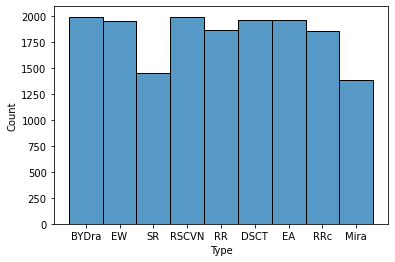

In [7]:
# Plot histogram of variable types in the dataset
import seaborn as sns
sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'ZZ'
    df1 = df0[df0.Type == 'ZZ']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=6000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_balanced = pd.concat(frames)
    return df0, df_balanced

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(name,model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets y_pred=clf.predict(X_test)
    if name == ("Isolation Forest" or "One Class SVM"):
        X_train = X_train[y_train==0]
        model.fit(X_train)
    elif name == "XGBoost":
        # define hyperparameters to optimize with range
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
        max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]  # Maximum number of levels in tree   
        eta = [.3, .2, .1, .05, .01, .005]
        subsample = [0.8, 0.9, 1]
        colsample_bytree = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        gamma =[0, 1, 5]
        random_grid = {'param_set1':{'n_estimators': n_estimators, 
               'max_depth': max_depth},
               'param_set2':{'eta': eta,
               'colsample_bytree' : colsample_bytree},
               'param_set3':{'gamma' : gamma,
               'subsample' : subsample}}
        # optimize 2 paramenters at a time
        for key in random_grid: 
            params = random_grid[key]
            xg_random = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
            xg_random.fit(X_train, y_train)
            model = xg_random.best_estimator_
    else:
        model.fit(X_train,y_train)

    # Predict test data output
    y_pred = model.predict(X_test)
    
    # Estimate model performance on test data
    if name == "Isolation Forest" or "One Class SVM":
        one_index = np.where(y_pred==1)
        y_pred[one_index] = 1
        negone_index = np.where(y_pred==-1)
        y_pred[negone_index] = 0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return model, accuracy, precision, recall, confusion

## Function to plot heat maps

In [11]:
# A simple categorical heatmap
# code from : https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Train and Compare Classifiers

In [12]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM

# names = ["Isolation Forest", "One Class SVM", "XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]
clf_names = ["XGBoost","RandomForest", "DecisionTree", "LogisticRegression", "NaiveBayes"]

classifiers = [
#     IsolationForest(contamination=0.01),
#     OneClassSVM(gamma='scale', nu=0.01),
    XGBClassifier(use_label_encoder=False),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(solver = 'liblinear',max_iter = 500),
    GaussianNB()]
    


In [13]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}
fitted_models={}

# create comparision dataframe
header = pd.MultiIndex.from_product([clf_names,
                                     ['acc.','preci.','recall']],
                                    names=['classifier','metric'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)
for name in clf_names:
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    fitted_models[name]={}

# train models and collect metrics on test data
for variable_type in label: #loop over different types of variable stars
    print(variable_type)
    df0, df_balanced = multiple_to_2labels(df,variable_type)
    X_train, X_test, y_train, y_test = preprocess_data(df0)
    for name, clf in zip(clf_names, classifiers): # loop over different classifiers
        print(name)
        clf, accuracy[name][variable_type],precision[name][variable_type],recall[name][variable_type], confusion[name][variable_type] = oneVSall_classiffier(name,clf,X_train, X_test, y_train, y_test)
        fitted_models[name][variable_type] = pickle.dumps(clf)
        # save the model to disk
        filename = '../pickles/'+name+'_'+variable_type+'.pkl'
        pickle.dump(clf, open(filename, 'wb'))
for name in clf_names:        
    pd_comparison.loc[:,(name,'acc.')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'preci.')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())
    


BYDra
XGBoost
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:21:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:33:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bi

DecisionTree
LogisticRegression
NaiveBayes
RRc
XGBoost
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[21:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[21:37:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[21:42:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eval

In [14]:
# print the comparision table
pd_comparison_rounded = pd_comparison.round(decimals=2)
pd_comparison_rounded.head(20)

classifier XGBoost               RandomForest               DecisionTree  \
metric        acc. preci. recall         acc. preci. recall         acc.   
BYDra         0.88   0.91   0.96         0.89   0.90   0.98         0.88   
EW            0.93   0.95   0.97         0.93   0.94   0.98         0.88   
SR            0.97   0.97   0.99         0.97   0.97   1.00         0.93   
RSCVN         0.89   0.91   0.97         0.89   0.91   0.98         0.89   
RR            0.97   0.98   0.99         0.97   0.97   0.99         0.94   
DSCT          0.92   0.94   0.97         0.91   0.93   0.98         0.88   
EA            0.98   0.99   0.99         0.98   0.99   0.99         0.97   
RRc           0.96   0.97   0.99         0.96   0.96   0.99         0.94   
Mira          1.00   1.00   1.00         1.00   1.00   1.00         1.00   

classifier               LogisticRegression               NaiveBayes         \
metric     preci. recall               acc. preci. recall       acc. preci.   
BYDra        0.88   1.00               0.88   0.88   0.99       0.50   0.99   
EW           0.88   1.00               0.89   0.90   0.99       0.30   0.99   
SR           0.94   0.99               0.96   0.96   0.99       0.23   0.96   
RSCVN        0.89   1.00               0.88   0.88   1.00       0.51   0.99   
RR           0.96   0.98               0.96   0.97   0.99       0.73   0.99   
DSCT         0.89   0.99               0.89   0.90   0.98       0.42   0.98   
EA           0.98   0.98               0.98   0.98   0.99       0.43   0.99   
RRc          0.94   0.99               0.95   0.96   0.98       0.71   0.99   
Mira         1.00   1.00               1.00   1.00   1.00       0.98   1.00   

classifier         
metric     recall  
BYDra        0.43  
EW           0.20  
SR           0.16  
RSCVN        0.45  
RR           0.70  
DSCT         0.35  
EA           0.35  
RRc          0.67  
Mira         0.98

## Scaled Feature importance for each one vs all classifier

In [15]:
# create tabe of feature importance
pd_feature = pd.DataFrame(columns=label,index=X_train.columns.values)

In [16]:
for variable_type in label:
    clf_XGBoost =  pickle.loads(fitted_models['XGBoost'][variable_type])
    pd_feature[variable_type] = clf_XGBoost.feature_importances_/max(clf_XGBoost.feature_importances_)

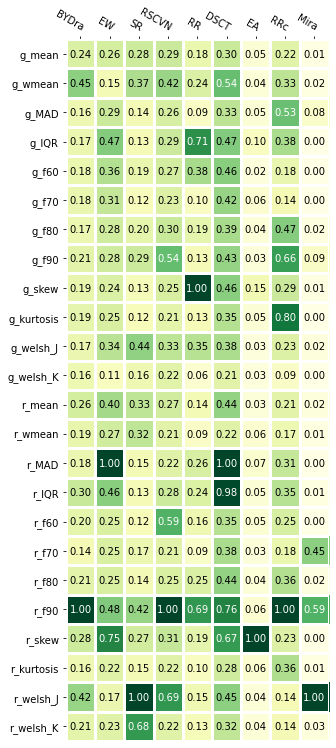

In [17]:
feature_imp = pd_feature.to_numpy()
xlabel = pd_feature.columns.values
ylabel = pd_feature.index.values
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
im = heatmap(feature_imp, ylabel, xlabel, ax=ax,
                   cmap="YlGn", cbarlabel="Scaled feature importance")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [18]:
# feature importance in table format
pd_feature.head(25)

,BYDra,EW,SR,RSCVN,RR,DSCT,EA,RRc,Mira
g_mean,0.243202,0.264793,0.283143,0.291487,0.176627,0.295988,0.049705,0.215229,0.008664
g_wmean,0.449477,0.145674,0.368509,0.419369,0.243645,0.537680,0.035868,0.328825,0.015191
g_MAD,0.163408,0.289052,0.142315,0.256669,0.091566,0.328884,0.047041,0.528568,0.078418
g_IQR,0.172541,0.469945,0.132957,0.291788,0.708760,0.474594,0.102708,0.382371,0.000000
g_f60,0.178735,0.362534,0.186089,0.265690,0.384873,0.460560,0.024589,0.179830,0.000000
g_f70,0.182464,0.312362,0.116694,0.231559,0.100959,0.422769,0.058422,0.140081,0.000000
g_f80,0.171491,0.275102,0.196477,0.300751,0.193770,0.386229,0.036639,0.466415,0.022717
g_f90,0.207894,0.280409,0.288269,0.541895,0.134339,0.426639,0.032504,0.660414,0.088547
g_skew,0.189070,0.242316,0.129505,0.250107,1.000000,0.460877,0.149350,0.291359,0.012159
g_kurtosis,0.194266,0.251629,0.124491,0.206535,0.128376,0.353889,0.049207,0.804928,0.000000


In [19]:
pd_comparison.to_csv('comparison_unbalanced.csv')

## Optimized XGB classifier parameters

In [20]:
n_estimators = []
max_depth = []
learning_rate = []
colsample_bytree =[]
gamma =[]
subsample = []
for variable_type in label:
    clf_XGB = pickle.loads(fitted_models['XGBoost'][variable_type])
    params = clf_XGB.get_params()
    n_estimators.append(params['n_estimators'])
    max_depth.append(params['max_depth'])
    learning_rate.append(params['learning_rate'])
    colsample_bytree.append(params['colsample_bytree'])
    gamma.append(params['gamma'])
    subsample.append(params['subsample'])
pd_XGB_optimized = pd.DataFrame(index=label,columns=['n_estimators','max_depth','learning_rate','colsample_bytree','gamma','subsample'])
pd_XGB_optimized['n_estimators'] =n_estimators
pd_XGB_optimized['max_depth'] = max_depth
pd_XGB_optimized['learning_rate'] = learning_rate
pd_XGB_optimized['colsample_bytree'] = colsample_bytree
pd_XGB_optimized['gamma'] = gamma
pd_XGB_optimized['subsample'] = subsample

In [21]:
pd_XGB_optimized.head(10)

,n_estimators,max_depth,learning_rate,colsample_bytree,gamma,subsample
BYDra,645,82,0.3,0.7,5,1.0
EW,700,46,0.3,0.8,0,0.8
SR,290,19,0.3,0.8,5,1.0
RSCVN,290,19,0.3,0.8,5,1.0
RR,290,19,0.3,0.8,0,0.8
DSCT,290,19,0.3,0.7,0,0.8
EA,290,19,0.3,0.5,1,1.0
RRc,645,82,0.3,0.5,0,0.8
Mira,645,82,0.3,0.7,5,0.9


## Compare outputs of all optimized XG Boot Classifiers on all the data

In [22]:
def preprocess_data2(df):
    """
    Preprocess data for one vs all classifier.
    Return the features dataframe and labels
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    # Encode labels to form y labels
    y = le.transform(df.Type)
    return X, y

In [23]:
def find_probabilities(fitted_models,df,variable_type):
    """
    Push all the data through a 1 vs all classfier. 
    Return the classification probabilities in the two clsses
    """
    df0,df_oneVsAll = multiple_to_2labels(df,variable_type)
    X, y = preprocess_data2(df0)
    clf_XGBoost =  pickle.loads(fitted_models['XGBoost'][variable_type])
#     print(clf_XGBoost.feature_importances_)
    y_prob = clf_XGBoost.predict_proba(X)
    return y_prob

In [24]:
# iterate over 1 vs all XG Boost classifiers for all varaibles and find probabilities
all_probs={}
for variable_type in label:
#     print(variable_type)
    all_probs[variable_type] = find_probabilities(fitted_models,df,variable_type)

In [25]:
# # plot the probabilities from 2 classifiers at a time using kernel density function and matplot lib contours

# n = len(label)
# j = 0
# for i in range(0,n):
#     for k in range(i+1,n):
#         j = j+1
#         variable_type1 = label[i]
#         variable_type2 = label[k]
#         df_prob = pd.DataFrame(columns=[variable_type1, variable_type2, 'Type'])
#         prob1 = all_probs[variable_type1][:,0]
#         prob2 = all_probs[variable_type2][:,0]
#         df_prob[variable_type1] = prob1
#         df_prob[variable_type2] = prob2
#         ind1 = df.index[df['Type']==variable_type1].values
#         ind2 = df.index[df['Type']==variable_type2].values
#         ind3 = df.index[(df['Type'] != variable_type1) & (df['Type'] != variable_type2)]
        
        
#         df_prob.loc[ind1,'Type'] = variable_type1
#         df_prob.loc[ind2,'Type'] = variable_type2
#         df_prob.loc[ind3,'Type'] = 'Other' 
        
#         title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
#         fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
#         try:
#             sns.kdeplot(data = df_prob,x=variable_type1,y=variable_type2, ax=ax1, hue='Type')
#         except:
#             continue
        
        
#         H, xedges, yedges = np.histogram2d(prob1[ind3],prob2[ind3], bins=(5,5))
#         contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='blue')
#         ax2.set_xlim([0,1.1])
#         ax2.set_ylim([0,1.1])
#         ax2.clabel(contours,fmt = '%2.1d', inline=True, fontsize=8)
        
        
#         H, xedges, yedges = np.histogram2d(prob1[ind1],prob2[ind1], bins=(5,5))
#         contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='red')
#         ax2.clabel(contours, fmt = '%2.1d', inline=True, fontsize=8)
        
#         H, xedges, yedges = np.histogram2d(prob1[ind2],prob2[ind2], bins=(5,5))
#         contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='green')
#         ax2.clabel(contours, fmt = '%2.1d', inline=True, fontsize=8)
        
#         plt.xlabel(variable_type1)
#         plt.ylabel(variable_type2)
#         title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
#         fig.suptitle(title_string)

#         plt.show()
#         del ind1, ind2, ind3, df_prob

        

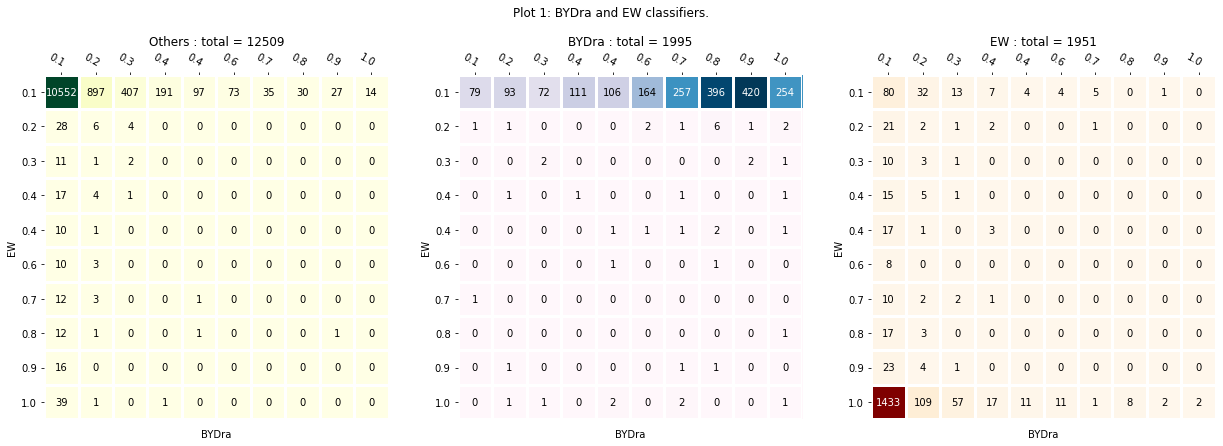

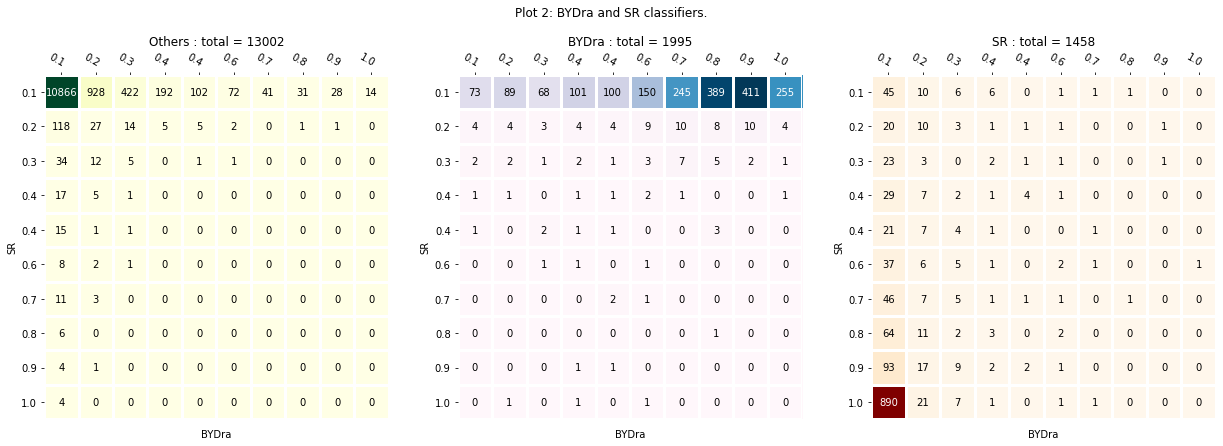

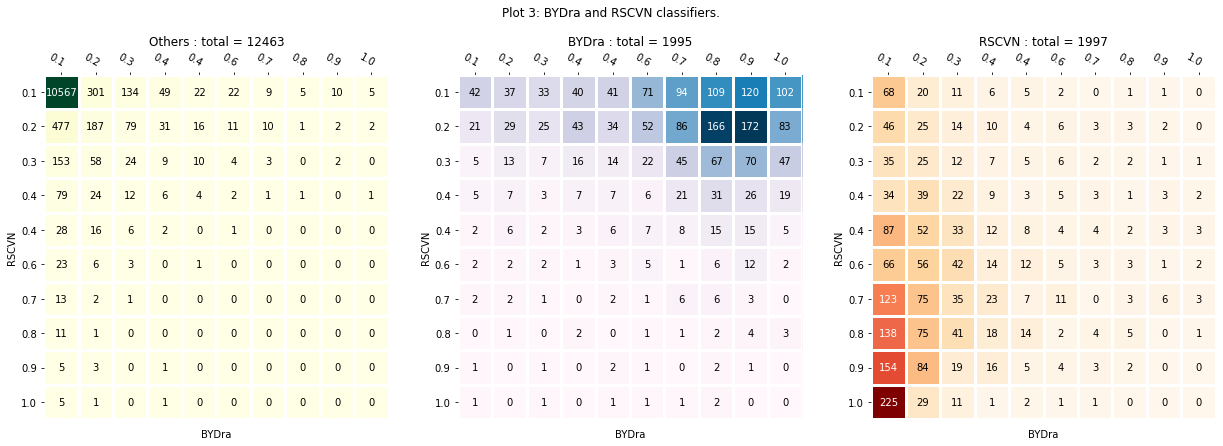

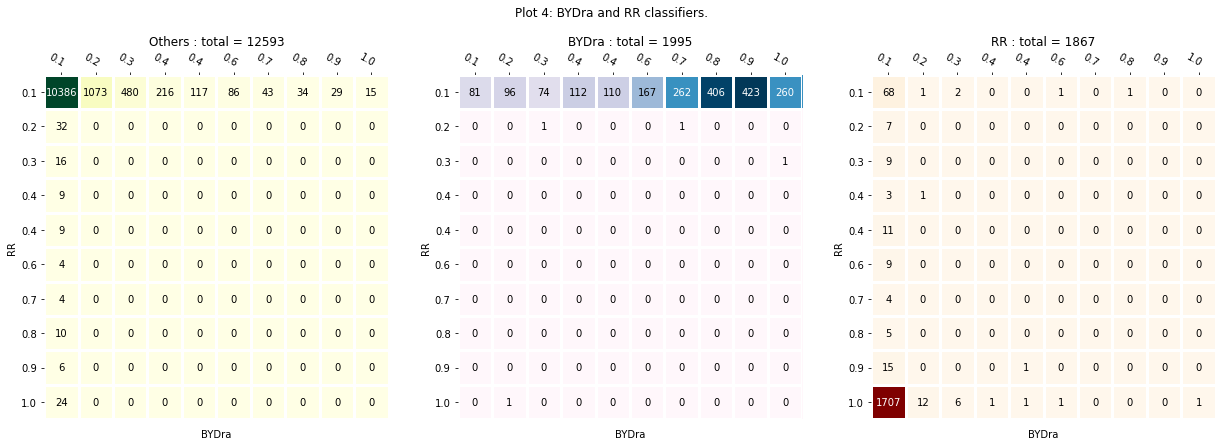

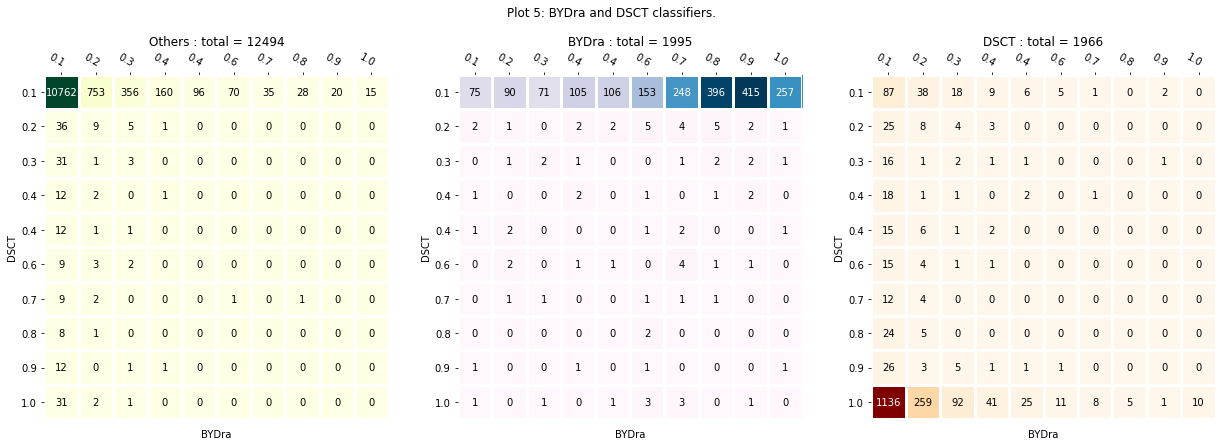

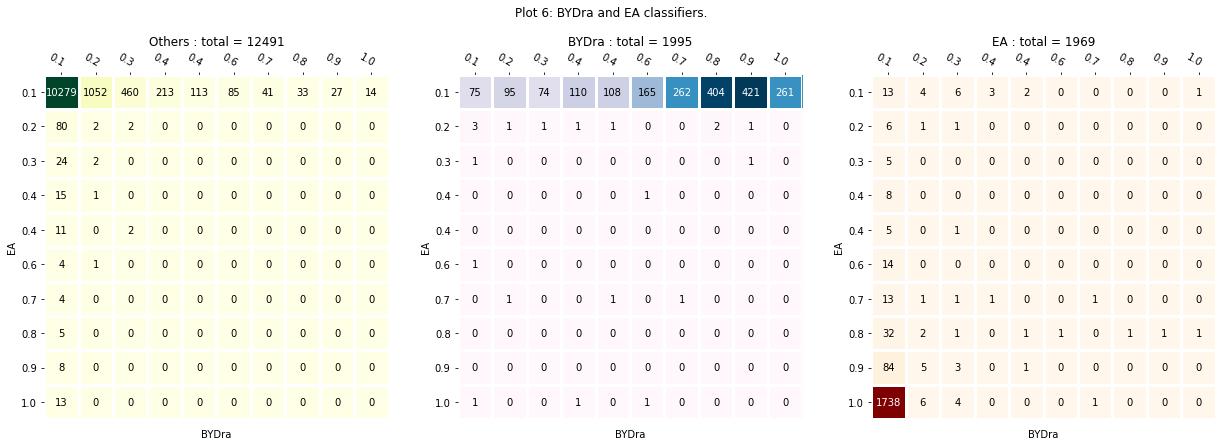

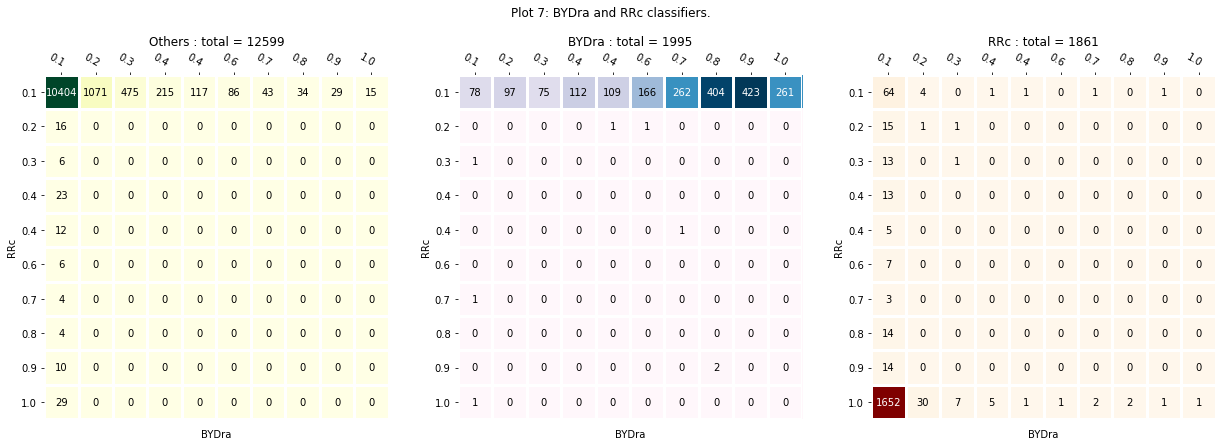

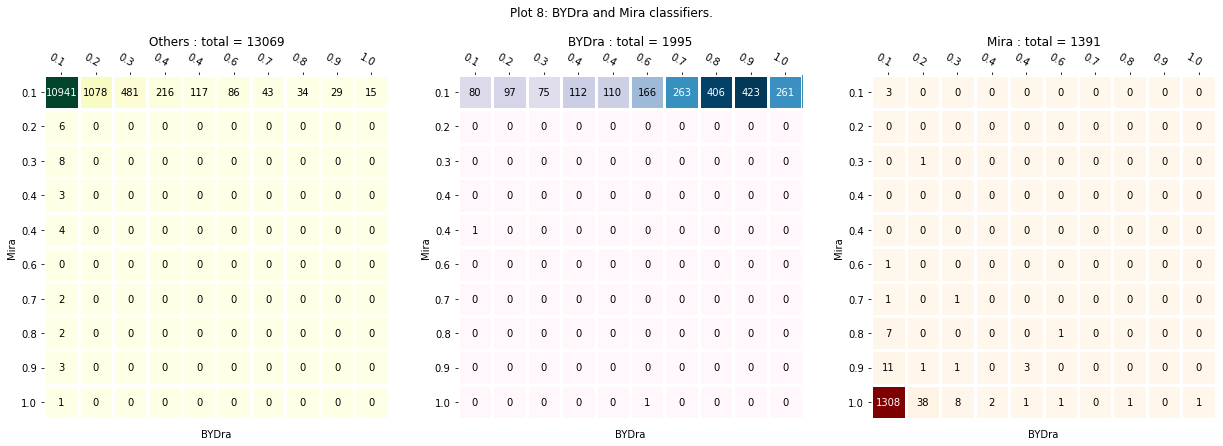

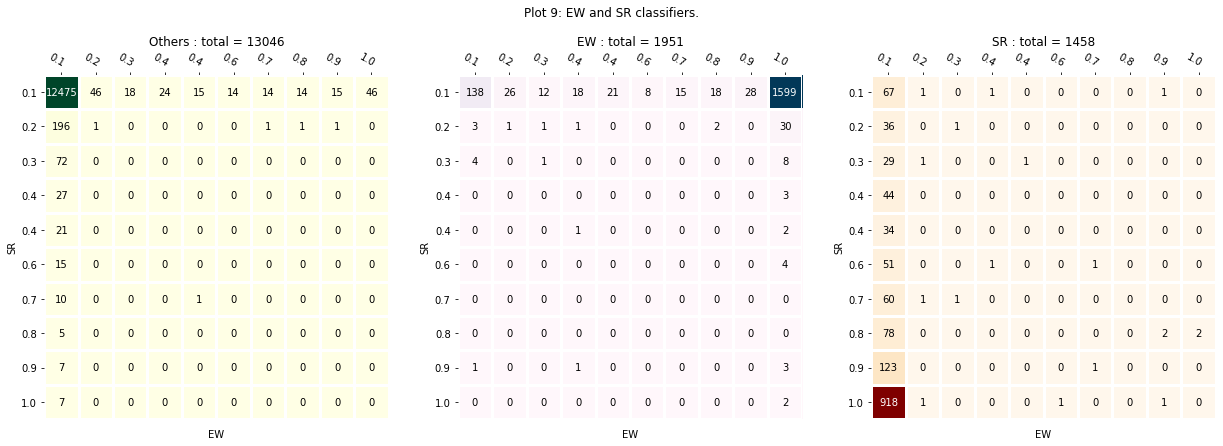

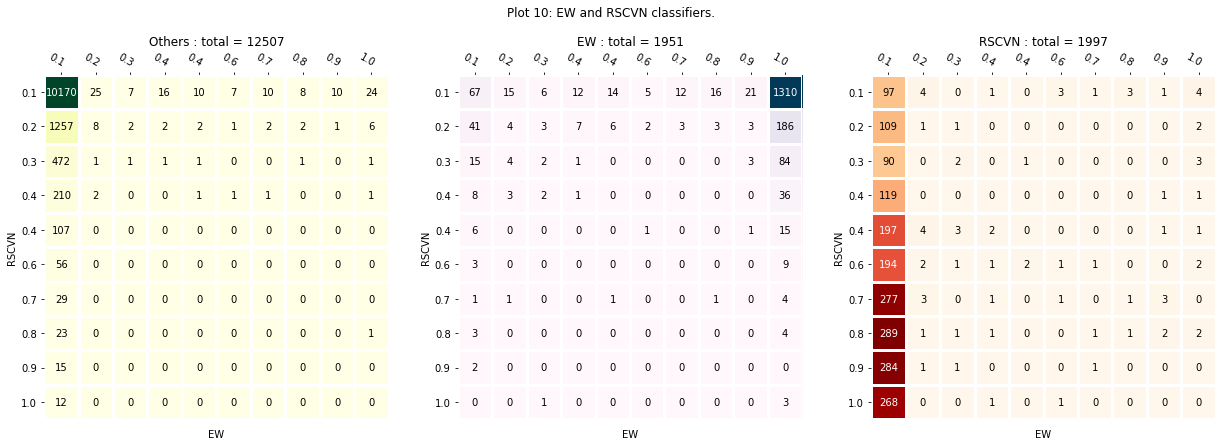

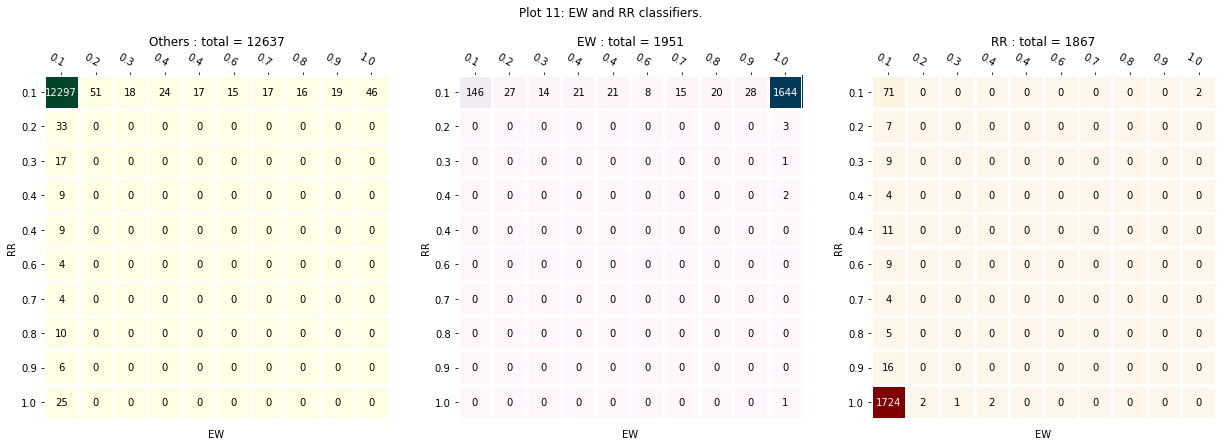

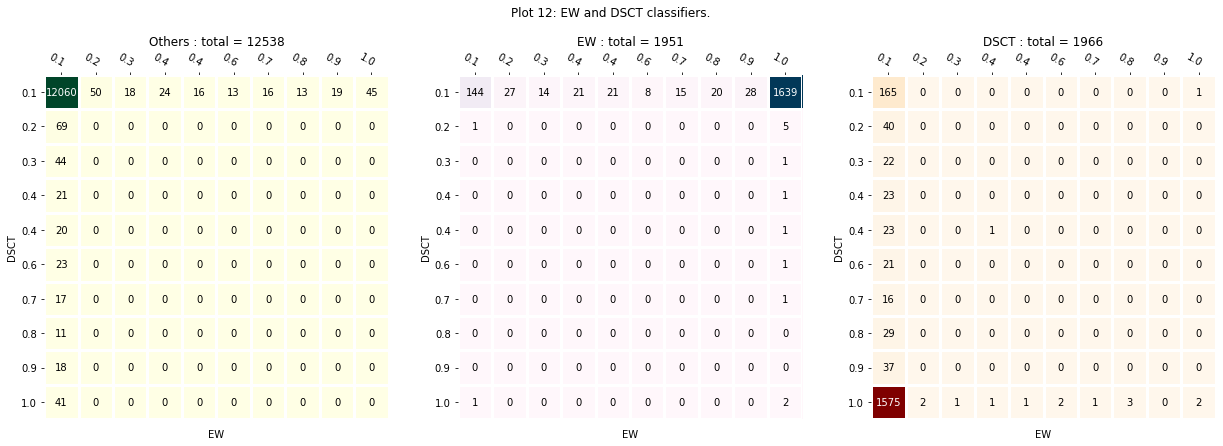

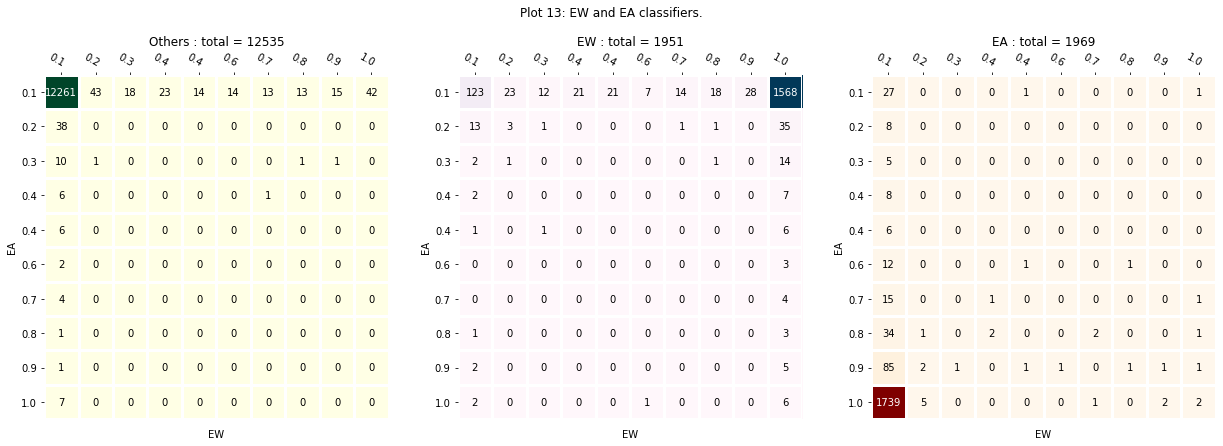

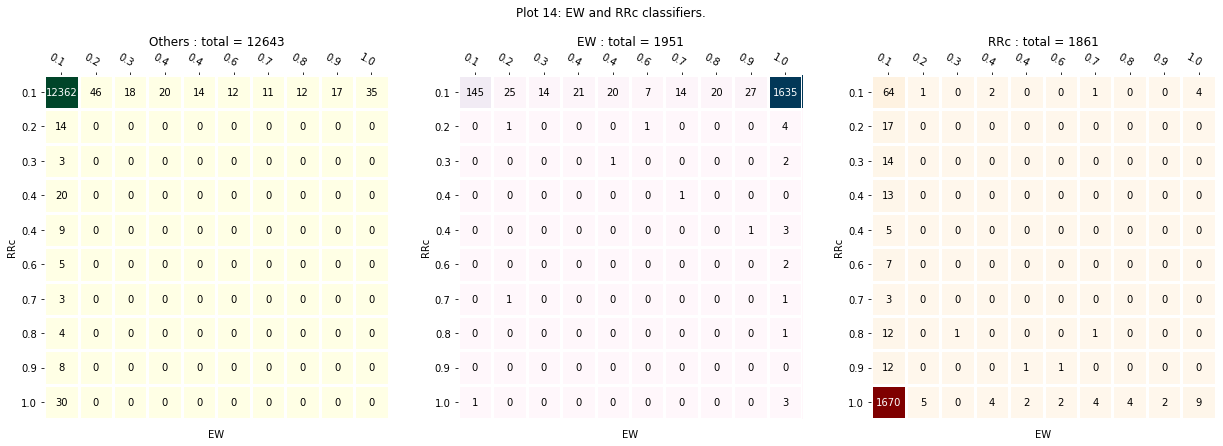

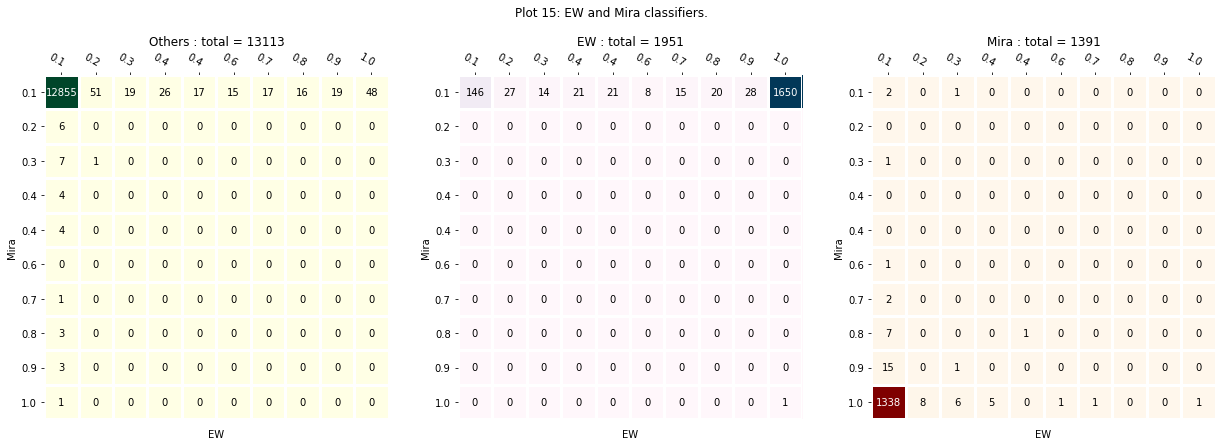

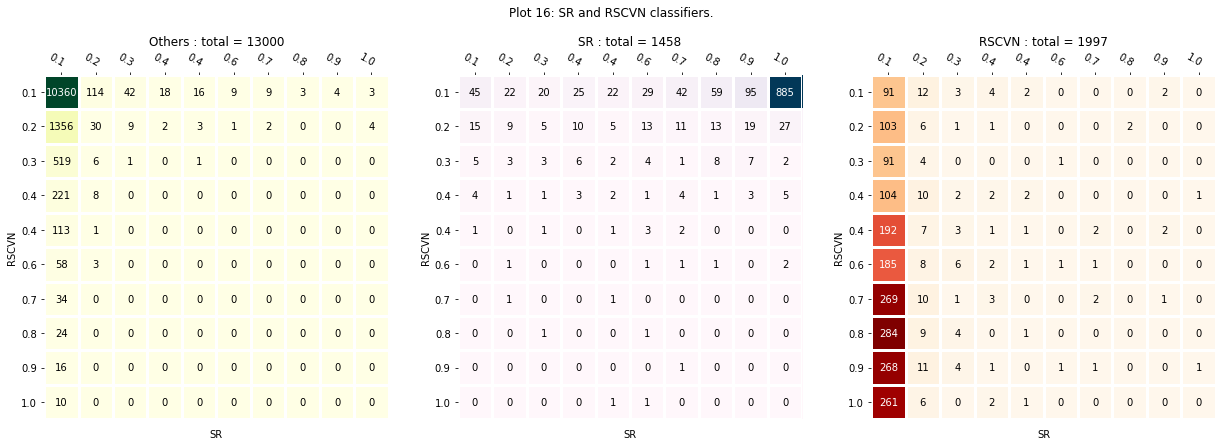

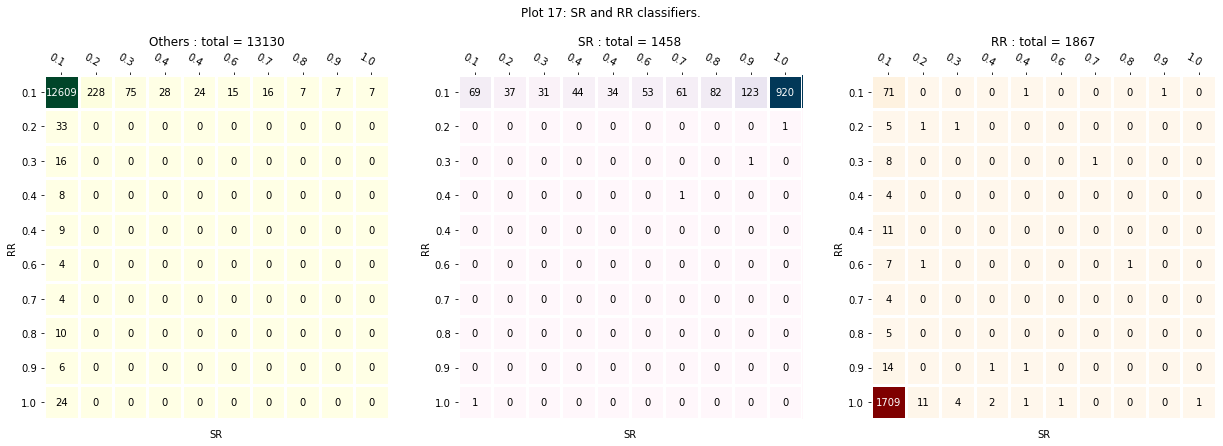

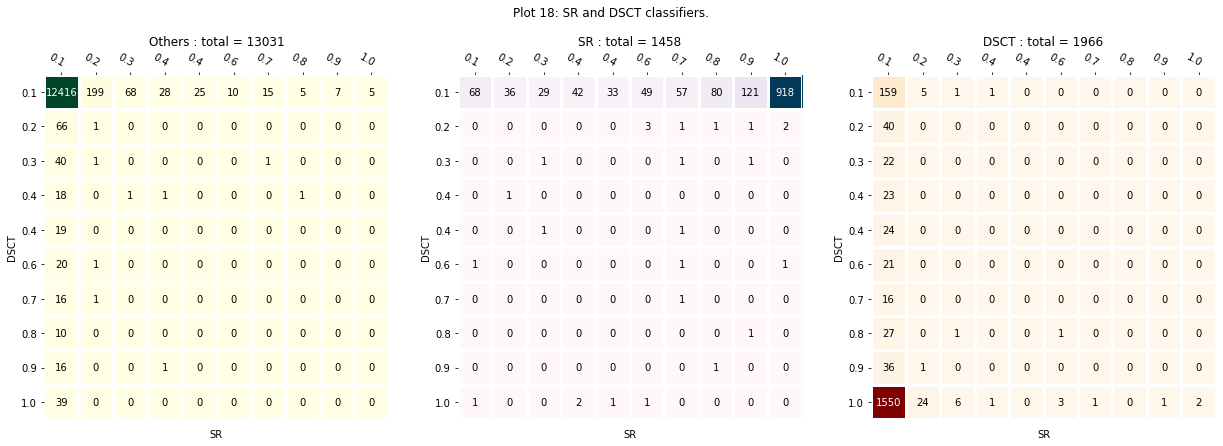

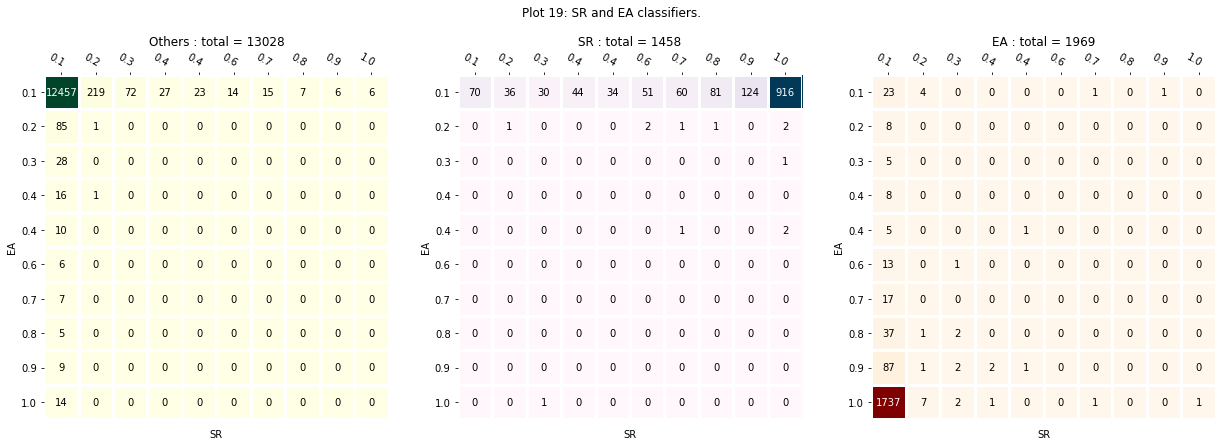

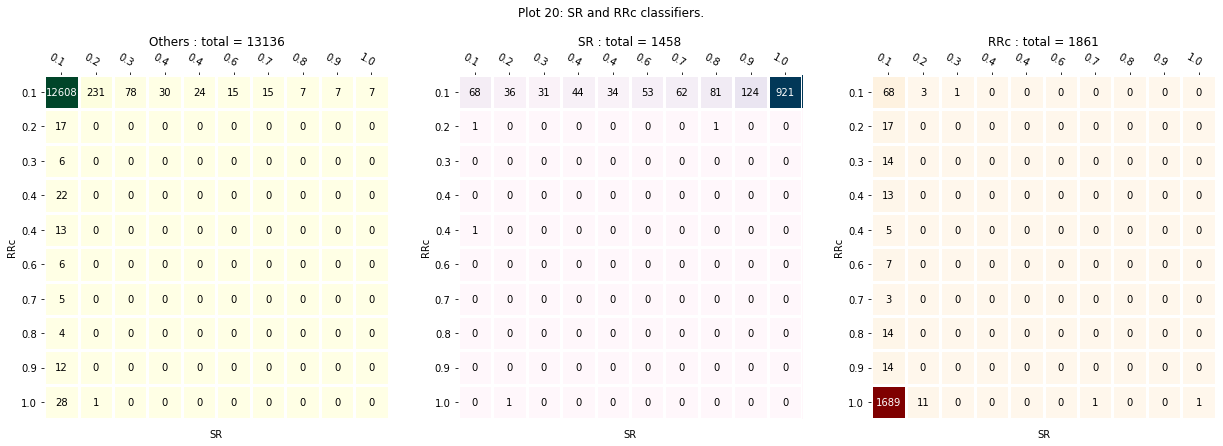

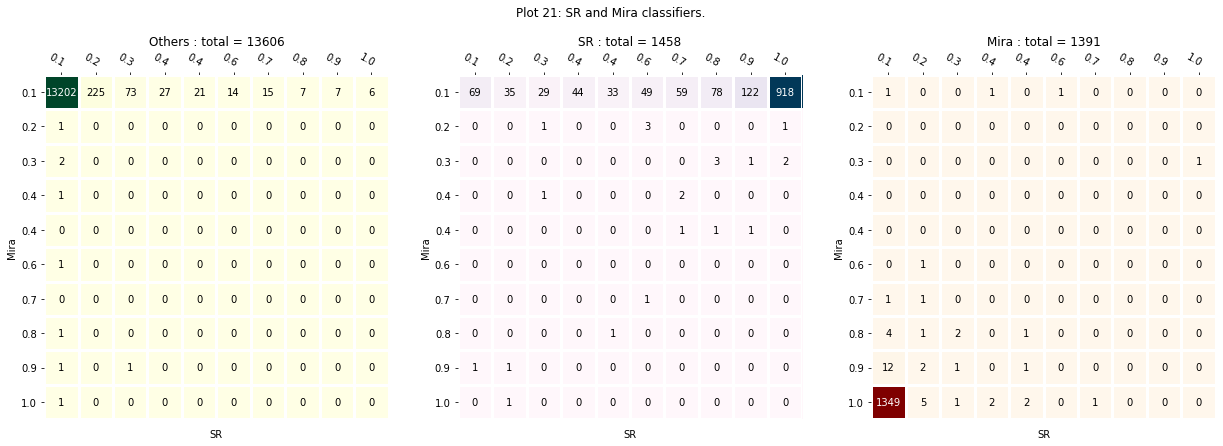

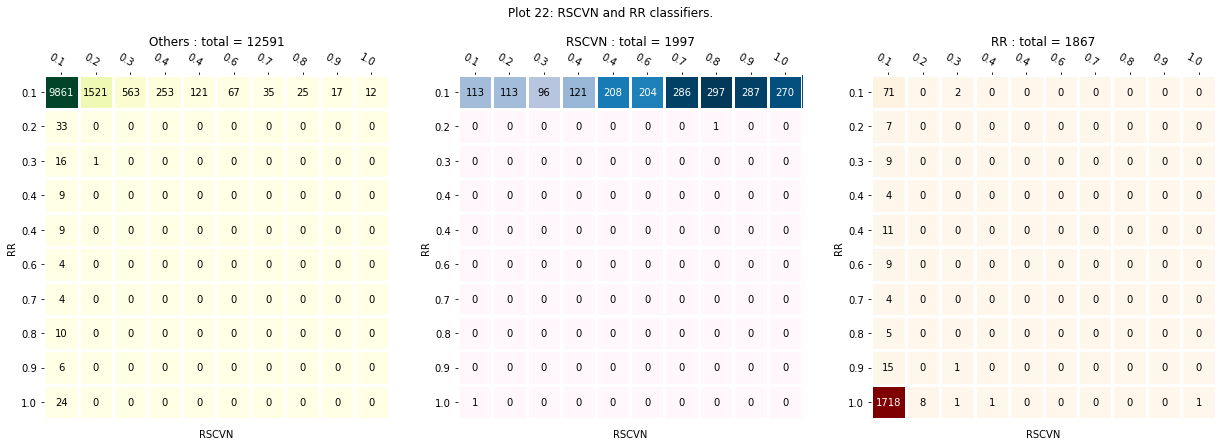

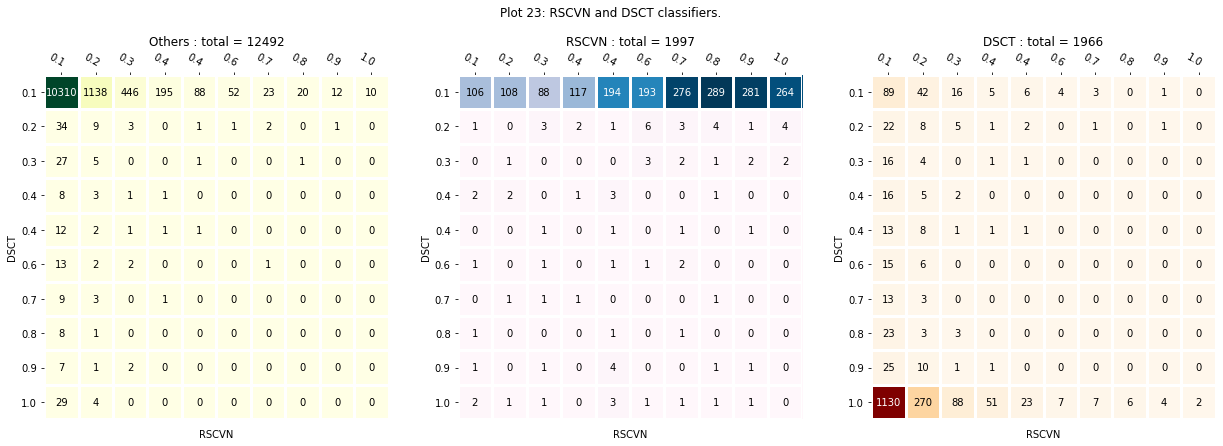

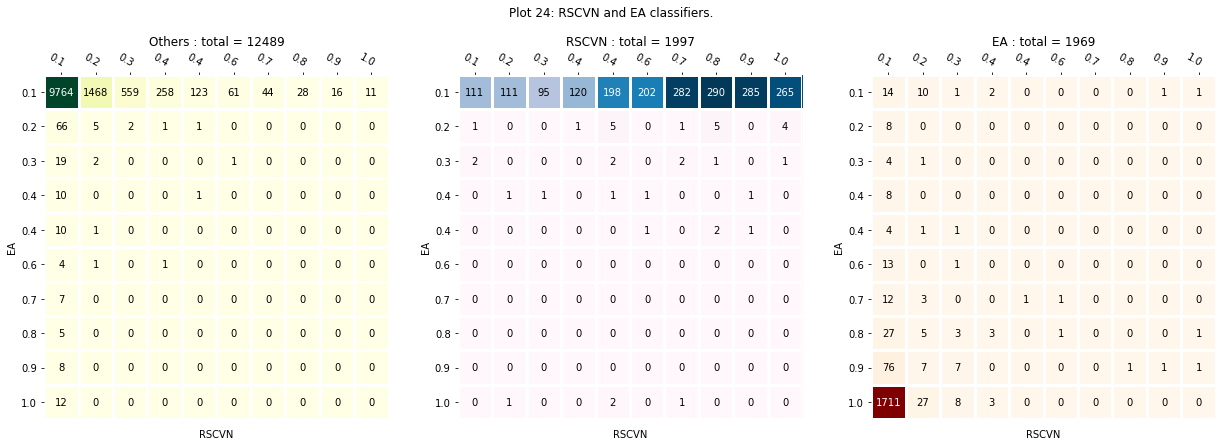

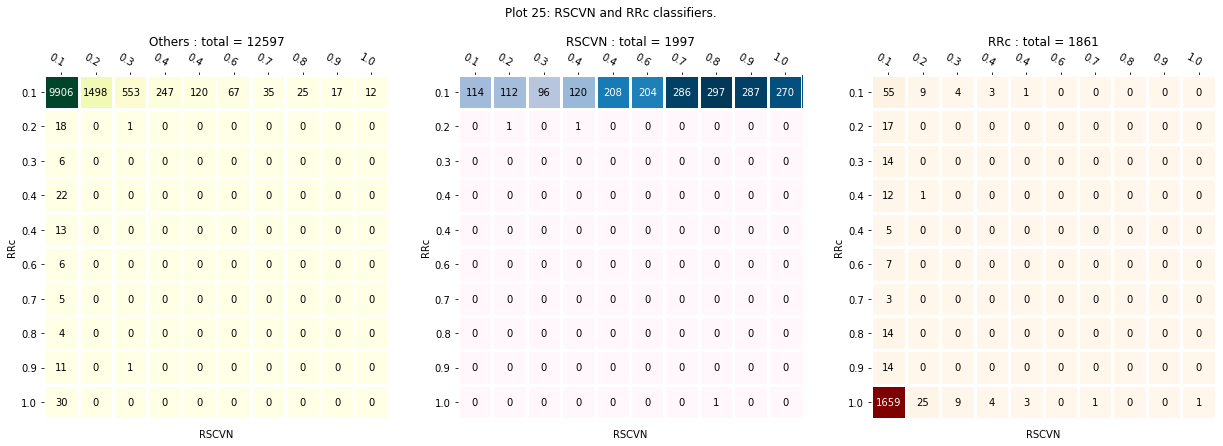

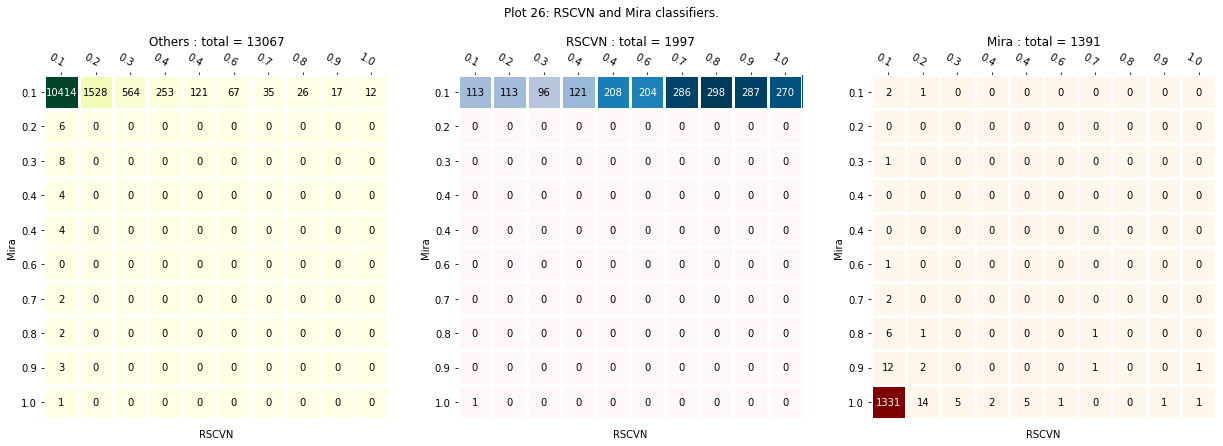

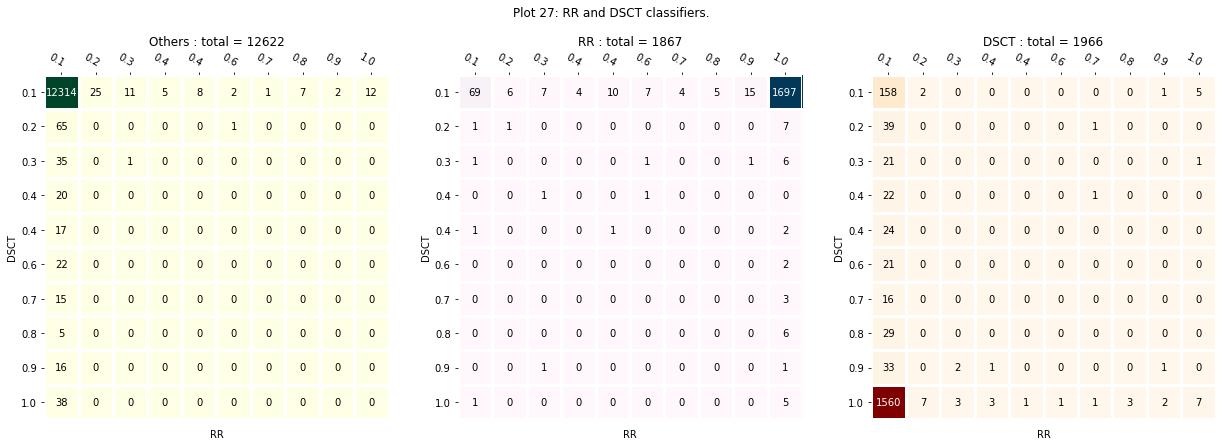

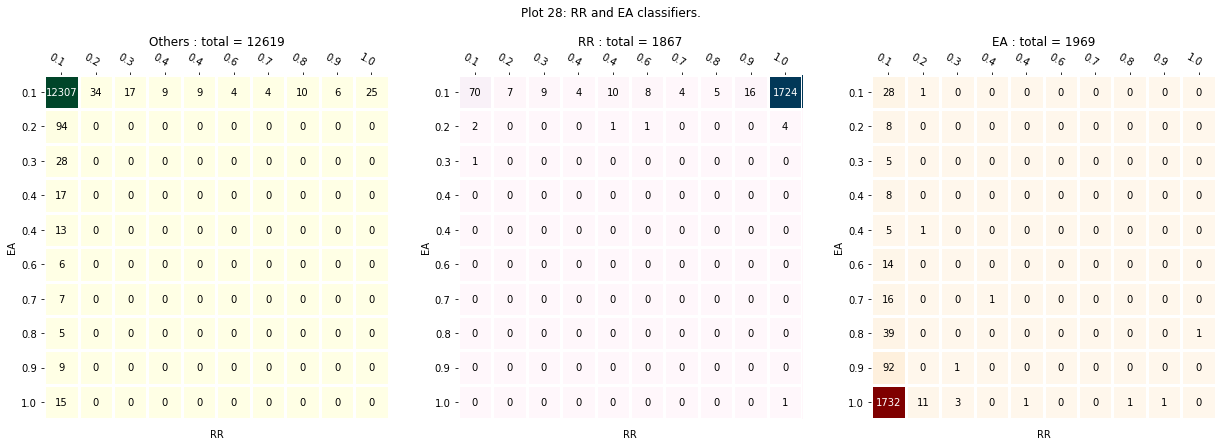

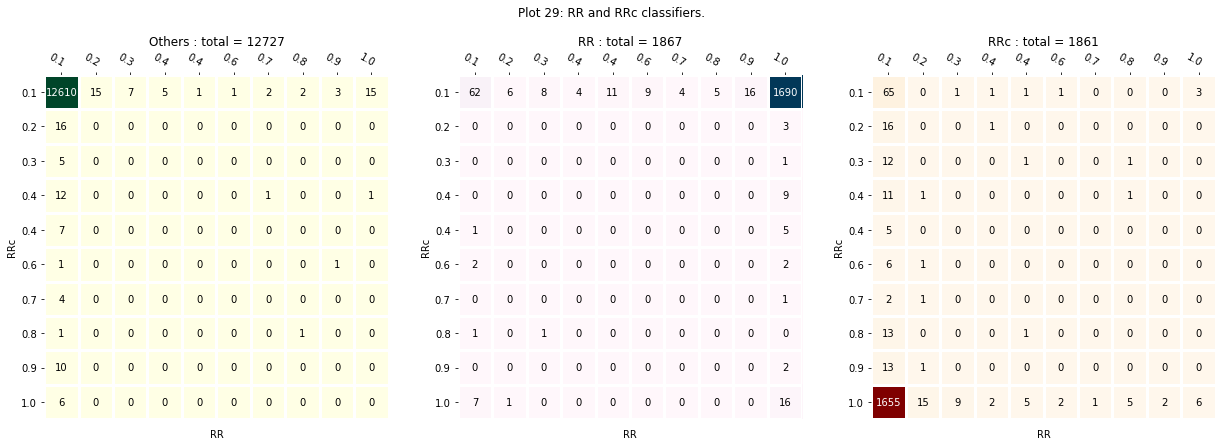

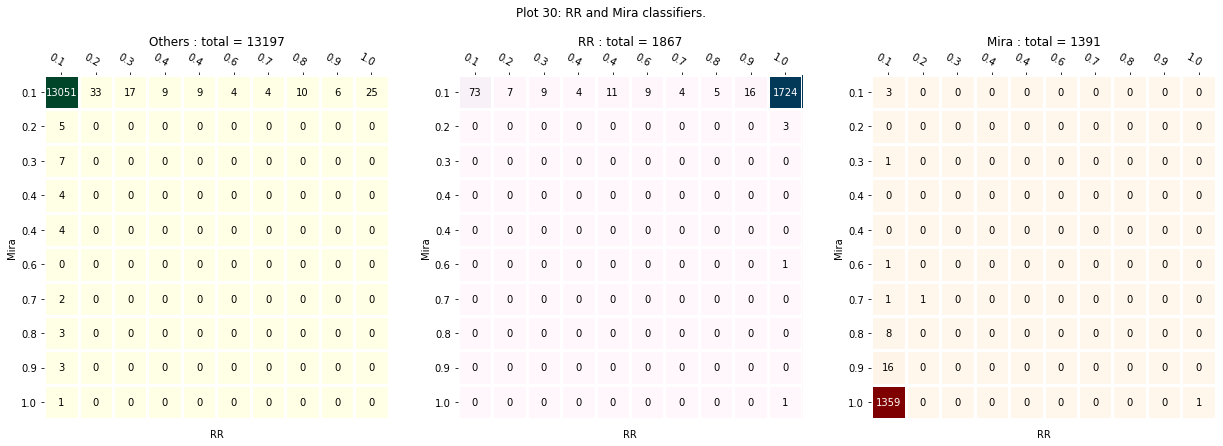

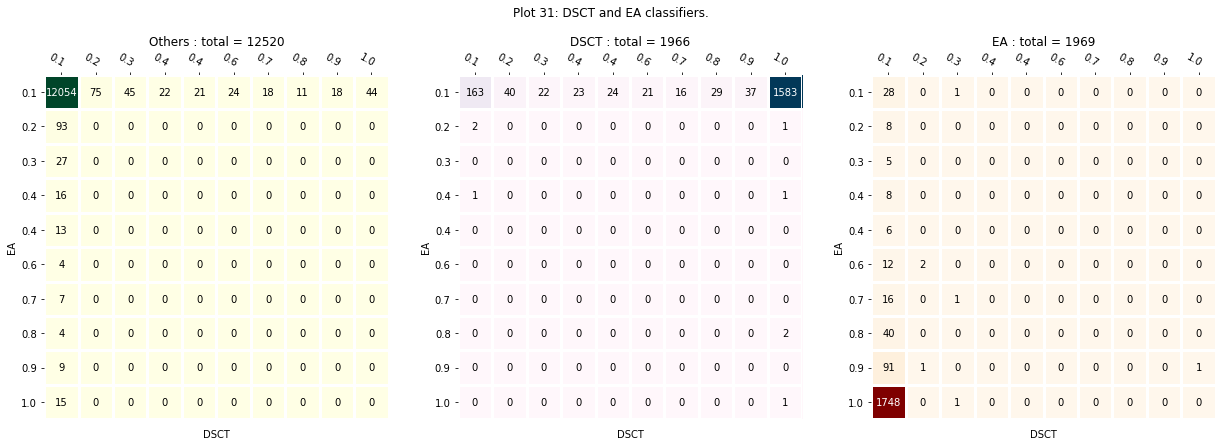

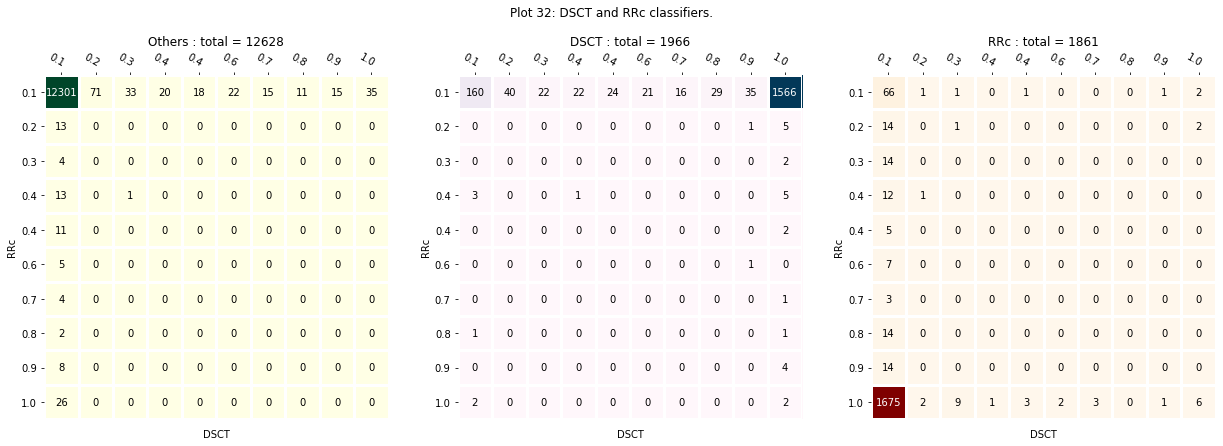

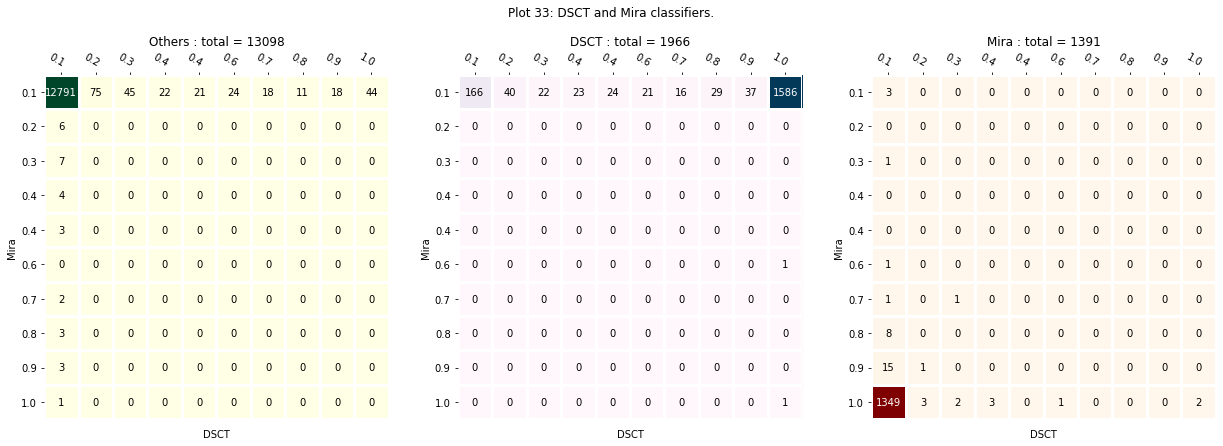

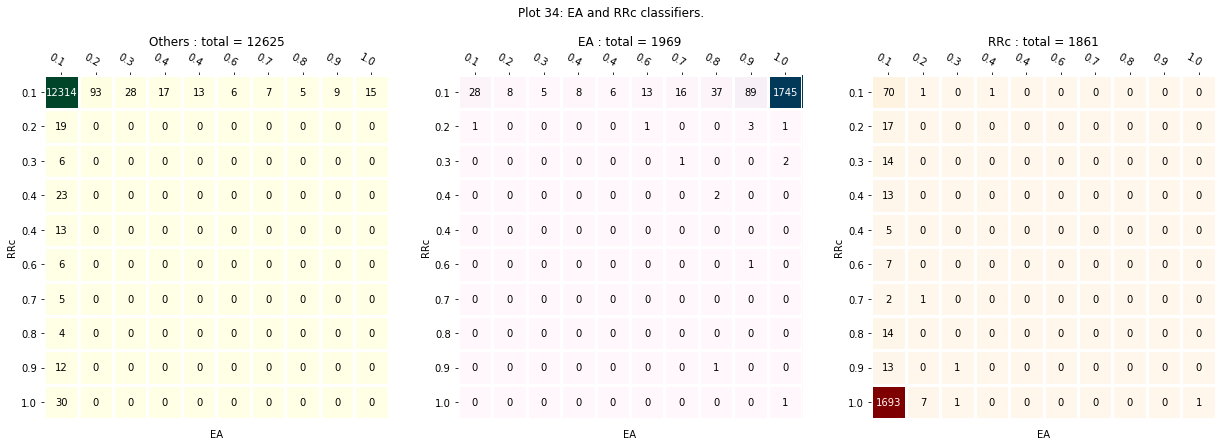

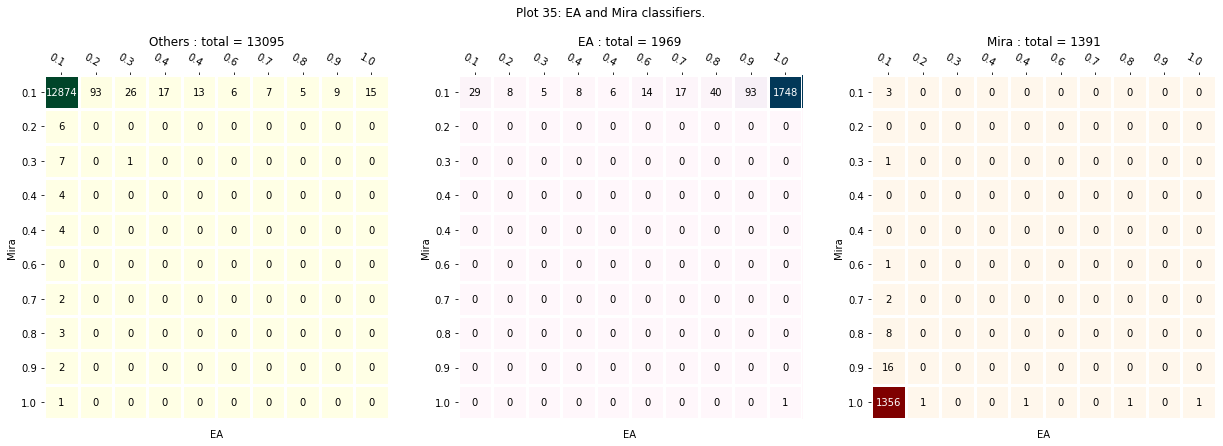

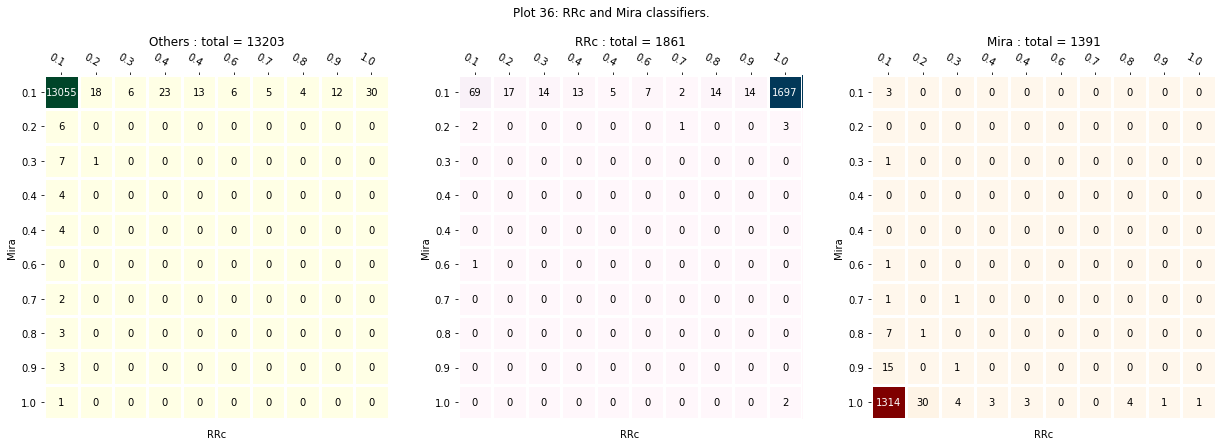

In [26]:
# plot the probabilities from 2 classifiers at a time using heatmap

n = len(label)
j = 0
for i in range(0,n):
    for k in range(i+1,n):
        j = j+1
        variable_type1 = label[i]
        variable_type2 = label[k]
        df_prob = pd.DataFrame(columns=[variable_type1, variable_type2, 'Type'])
        prob1 = all_probs[variable_type1][:,0]
        prob2 = all_probs[variable_type2][:,0]
        df_prob[variable_type1] = prob1
        df_prob[variable_type2] = prob2
        ind1 = df.index[df['Type']==variable_type1].values
        ind2 = df.index[df['Type']==variable_type2].values
        ind3 = df.index[(df['Type'] != variable_type1) & (df['Type'] != variable_type2)]
        
        
        df_prob.loc[ind1,'Type'] = variable_type1
        df_prob.loc[ind2,'Type'] = variable_type2
        df_prob.loc[ind3,'Type'] = 'Other' 
        
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        xbins = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']
        ybins = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']
        
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,7))

        
        H, xedges, yedges = np.histogram2d(prob1[ind3],prob2[ind3], bins=(10,10))
        ax1.set_xlabel(variable_type1)
        ax1.set_ylabel(variable_type2)
        title = "Others : total = {}".format(len(prob1[ind3]))
        ax1.set_title(title)
        im = heatmap(H.T, ybins, xbins, ax=ax1,
                           cmap="YlGn", cbarlabel="")
        texts = annotate_heatmap(im, valfmt="{x:n}")
        
        H, xedges, yedges = np.histogram2d(prob1[ind1],prob2[ind1], bins=(10,10))
        ax2.set_xlabel(variable_type1)
        ax2.set_ylabel(variable_type2)
        title = "{} : total = {}".format(variable_type1,len(prob1[ind1]))
        ax2.set_title(title)
        im  = heatmap(H.T, ybins, xbins, ax=ax2,
                           cmap="PuBu", cbarlabel="")
        texts = annotate_heatmap(im, valfmt="{x:n}")
        
        H, xedges, yedges = np.histogram2d(prob1[ind2],prob2[ind2], bins=(10,10))
        ax3.set_xlabel(variable_type1)
        ax3.set_ylabel(variable_type2)
        title = "{} : total = {}".format(variable_type2,len(prob1[ind2]))
        ax3.set_title(title)
        im  = heatmap(H.T, ybins, xbins, ax=ax3,
                           cmap="OrRd", cbarlabel="")
        texts = annotate_heatmap(im, valfmt="{x:n}")
        
        fig.suptitle(title_string)
#         fig.tight_layout()
        plt.show()


## Notes:
1. Each classifiers was trained on ~6000 balanced datapoints from a total data ~20000 points.
1. Each one vs all classifier had high accuracy, precision and recall (>80% or 90% in most cases) for XG Boost classifier
1. To improve classification we need to 
    1. Add more features especially pertaining to period calculation
    1. Use more data
1. The classifiers need to be trained with non variable star type data evntually
1. To make the classifiers usable there needs to be a python tool chain to run new data through all 9 classifiers and give production probability for all 9 classes simultaneously. If more 90% of the data can be correctly classifer to only 1 of the 9 classes then the method maybe useful. 